1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import lightgbm as lgb
import shap
import pickle

2. Loading and Features

In [2]:
df = pd.read_csv("Churn.csv")  # replace with your path
target_col = "Churn Flag"

numeric_features = [
    "Number of Dependents", 
    "Income", 
    "Customer Tenure", 
    "Outstanding Loans", 
    "Balance", 
    "NumOfProducts", 
    "NumComplaints"
]

categorical_features = [
    "Gender", 
    "Marital Status",  
    "Education Level", 
    "Customer Segment", 
]

# Getting age from DOB
from datetime import datetime
df["Age"] = df["Date of Birth"].apply(lambda dob: datetime.now().year - int(dob.split("-")[2]))
numeric_features.append("Age")

X = df[numeric_features + categorical_features]
y = df["Churn Flag"]

3. Train/Validation/Test Split

In [3]:
# Train 60% | Val 20% | Test 20% 
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)  


# Preprocessing
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")


4. Training and Pipeline

In [4]:
lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "num_leaves": [31, 50, 70],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.05, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    lgb_clf, param_grid, cv=cv, scoring="f1", n_jobs=-1)

grid.fit(X_train, y_train)

,estimator,LGBMClassifie...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [-1, 10, ...], 'num_leaves': [31, 50, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


5. Evaluate on validation

In [5]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:, 1]

print("=== Validation Metrics ===")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
print("PR-AUC:", auc(recall, precision))


=== Validation Metrics ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     20309
           1       0.79      0.76      0.78      2819

    accuracy                           0.95     23128
   macro avg       0.88      0.87      0.87     23128
weighted avg       0.95      0.95      0.95     23128

Confusion Matrix:
[[19740   569]
 [  663  2156]]
ROC-AUC: 0.9822899732303697
PR-AUC: 0.8864168716256124


6. Retrain on train+val and evaluate test

In [6]:
best_model = grid.best_estimator_
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Test Metrics ===")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
print("PR-AUC:", auc(recall, precision))


=== Test Metrics ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     20309
           1       0.81      0.79      0.80      2819

    accuracy                           0.95     23128
   macro avg       0.89      0.88      0.89     23128
weighted avg       0.95      0.95      0.95     23128

Confusion Matrix:
[[19767   542]
 [  579  2240]]
ROC-AUC: 0.9848724576698312
PR-AUC: 0.9033512888392016


7. Saving Model for Deployment

In [7]:
with open("lgbm_churn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("\nModel saved as lgbm_churn_model.pkl")


Model saved as lgbm_churn_model.pkl


8. SHAP explainability

c:\Users\Lloyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


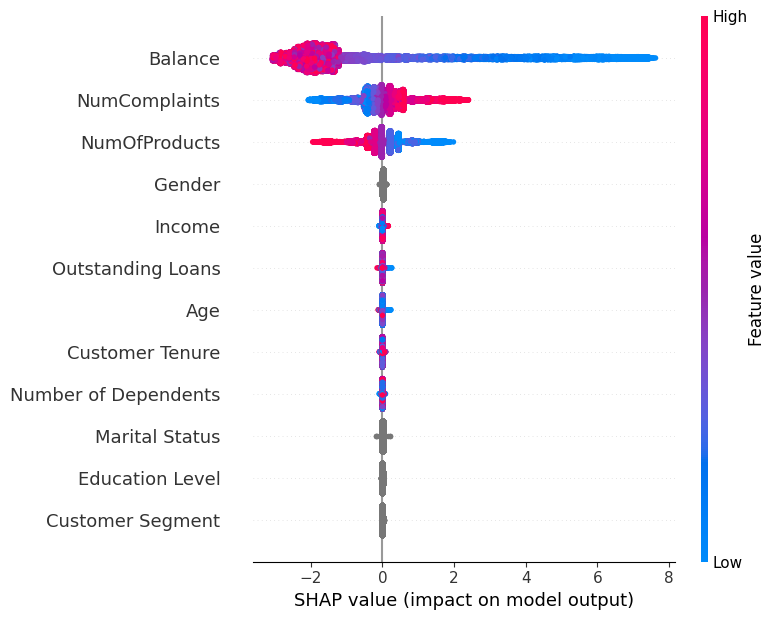

In [8]:
# Feature names are just the column names of X_test
feature_names = X_test.columns

# SHAP explainer on the trained model directly
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# For binary classification, take the positive class (class 1)
shap_to_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

# Summary plot
shap.summary_plot(shap_to_plot, X_test, feature_names=feature_names)